In [1]:
# --- 📚 Import Libraries ---
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# --- 🎛️ Loading the pre-processed spectrograms and labels from the .npy files.

print("--- Loading data from .npy files ---")

# Paths to the pre-processed data files
spectrograms_path = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_data/mydata_spectrograms.npy"
labels_path = "/Users/anuragde/Documents/project-work/finalsubmission/preprocessed_data/mydata_labels.npy"

all_spectrograms = np.load(spectrograms_path)
all_labels = np.load(labels_path)

print(f"Loaded Spectrograms Shape: {all_spectrograms.shape}")
print(f"Loaded Labels Shape: {all_labels.shape}")
print(f"Label distribution: {pd.Series(all_labels).value_counts().to_dict()}")

--- Loading data from .npy files ---
Loaded Spectrograms Shape: (120000, 129, 153)
Loaded Labels Shape: (120000,)
Label distribution: {1: 60000, 0: 60000}


In [3]:
# --- Splitting Data  📁 (80% Train, 20% Validation) ---

print("--- Splitting data into 80% training and 20% validation sets ---")

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(
    all_spectrograms,
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

print(f"Training data shape: {train_spectrograms.shape}")
print(f"Validation data shape: {val_spectrograms.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")

--- Splitting data into 80% training and 20% validation sets ---
Training data shape: (96000, 129, 153)
Validation data shape: (24000, 129, 153)
Training labels shape: (96000,)
Validation labels shape: (24000,)


In [4]:
# --- 🧠 Define Dataset and Model Classes ---

class SpectrogramDataset(Dataset):
    """Custom PyTorch Dataset for loading spectrogram NumPy arrays."""
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.from_numpy(spectrograms)
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

class SignalCNN2D(nn.Module):
    """A 2D Convolutional Neural Network for spectrogram classification."""
    def __init__(self, input_shape):
        super(SignalCNN2D, self).__init__()
        c, h, w = input_shape
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        flattened_size = self._get_conv_output_size(input_shape)
        
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2))

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            return x.numel()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

In [5]:
# --- ⏳ Calculating model's accuracy on a given dataset ---

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy on a data loader"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for spectrograms, labels in data_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.unsqueeze(1)  # Add channel dimension
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [6]:
# --- ⏱️ Training Setup and Loop ---

# --- Configuration ---
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
CHECKPOINT_DIR = "mymodel"
BEST_MODEL_NAME = "best_model.pth" 

# --- Setup Device ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# --- Create DataLoaders ---
train_dataset = SpectrogramDataset(train_spectrograms, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SpectrogramDataset(val_spectrograms, val_labels)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Calculate Class Weights for Imbalanced Data ---
class_counts = pd.Series(train_labels).value_counts().sort_index()
weight_for_0 = len(train_labels) / (2 * class_counts[0])
weight_for_1 = len(train_labels) / (2 * class_counts[1])
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32).to(device)
print(f"Calculated class weights: {class_weights.cpu().numpy()}")

# --- Initialize Model, Loss, and Optimizer ---
H, W = train_spectrograms.shape[1], train_spectrograms.shape[2]
input_shape_for_model = (1, H, W)
cnn_model = SignalCNN2D(input_shape_for_model).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
best_val_accuracy = 0.0
best_epoch = 0
training_history = {'train_loss': [], 'val_accuracy': []}

print("\n--- Starting Model Training ---")
training_start_time = time.time() # Start timer

for epoch in range(EPOCHS):
    cnn_model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    for spectrograms, labels in progress_bar:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        spectrograms = spectrograms.unsqueeze(1)
        
        outputs = cnn_model(spectrograms)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_train_loss = running_loss / len(train_loader)
    val_accuracy = evaluate_model(cnn_model, val_loader, device)
    
    training_history['train_loss'].append(avg_train_loss)
    training_history['val_accuracy'].append(val_accuracy)
    
    print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        # Use the hardcoded model name for saving
        torch.save(cnn_model.state_dict(), os.path.join(CHECKPOINT_DIR, BEST_MODEL_NAME))

total_training_time = time.time() - training_start_time # Calculate total training time

print("\n--- Training Complete ---")
print(f"Total training time: {total_training_time:.2f} seconds") # Display total training time
print(f"Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}")

--- Using device: mps ---
Calculated class weights: [1. 1.]

--- Starting Model Training ---


Epoch 1/15: 100%|██████████| 3000/3000 [02:48<00:00, 17.81batch/s, loss=0.0266]


Epoch 1 Summary | Train Loss: 0.0756 | Val Accuracy: 0.9888


Epoch 2/15: 100%|██████████| 3000/3000 [01:20<00:00, 37.06batch/s, loss=0.0081]


Epoch 2 Summary | Train Loss: 0.0329 | Val Accuracy: 0.9920


Epoch 3/15: 100%|██████████| 3000/3000 [01:20<00:00, 37.47batch/s, loss=0.0016]


Epoch 3 Summary | Train Loss: 0.0248 | Val Accuracy: 0.9930


Epoch 4/15: 100%|██████████| 3000/3000 [01:20<00:00, 37.33batch/s, loss=0.1288]


Epoch 4 Summary | Train Loss: 0.0211 | Val Accuracy: 0.9940


Epoch 5/15: 100%|██████████| 3000/3000 [01:21<00:00, 36.84batch/s, loss=0.0008]


Epoch 5 Summary | Train Loss: 0.0181 | Val Accuracy: 0.9936


Epoch 6/15: 100%|██████████| 3000/3000 [01:18<00:00, 38.00batch/s, loss=0.1871]


Epoch 6 Summary | Train Loss: 0.0158 | Val Accuracy: 0.9955


Epoch 7/15: 100%|██████████| 3000/3000 [01:19<00:00, 37.73batch/s, loss=0.0459]


Epoch 7 Summary | Train Loss: 0.0136 | Val Accuracy: 0.9943


Epoch 8/15: 100%|██████████| 3000/3000 [01:18<00:00, 38.25batch/s, loss=0.0000]


Epoch 8 Summary | Train Loss: 0.0122 | Val Accuracy: 0.9950


Epoch 9/15: 100%|██████████| 3000/3000 [01:17<00:00, 38.77batch/s, loss=0.0001]


Epoch 9 Summary | Train Loss: 0.0111 | Val Accuracy: 0.9958


Epoch 10/15: 100%|██████████| 3000/3000 [01:20<00:00, 37.28batch/s, loss=0.0008]


Epoch 10 Summary | Train Loss: 0.0105 | Val Accuracy: 0.9947


Epoch 11/15: 100%|██████████| 3000/3000 [01:18<00:00, 38.24batch/s, loss=0.0001]


Epoch 11 Summary | Train Loss: 0.0101 | Val Accuracy: 0.9957


Epoch 12/15: 100%|██████████| 3000/3000 [01:18<00:00, 38.20batch/s, loss=0.0000]


Epoch 12 Summary | Train Loss: 0.0097 | Val Accuracy: 0.9961


Epoch 13/15: 100%|██████████| 3000/3000 [01:21<00:00, 36.74batch/s, loss=0.0491]


Epoch 13 Summary | Train Loss: 0.0097 | Val Accuracy: 0.9952


Epoch 14/15: 100%|██████████| 3000/3000 [01:18<00:00, 38.03batch/s, loss=0.0000]


Epoch 14 Summary | Train Loss: 0.0083 | Val Accuracy: 0.9958


Epoch 15/15: 100%|██████████| 3000/3000 [01:17<00:00, 38.57batch/s, loss=0.0018]


Epoch 15 Summary | Train Loss: 0.0092 | Val Accuracy: 0.9960

--- Training Complete ---
Total training time: 1392.84 seconds
Best validation accuracy: 0.9961 at epoch 12


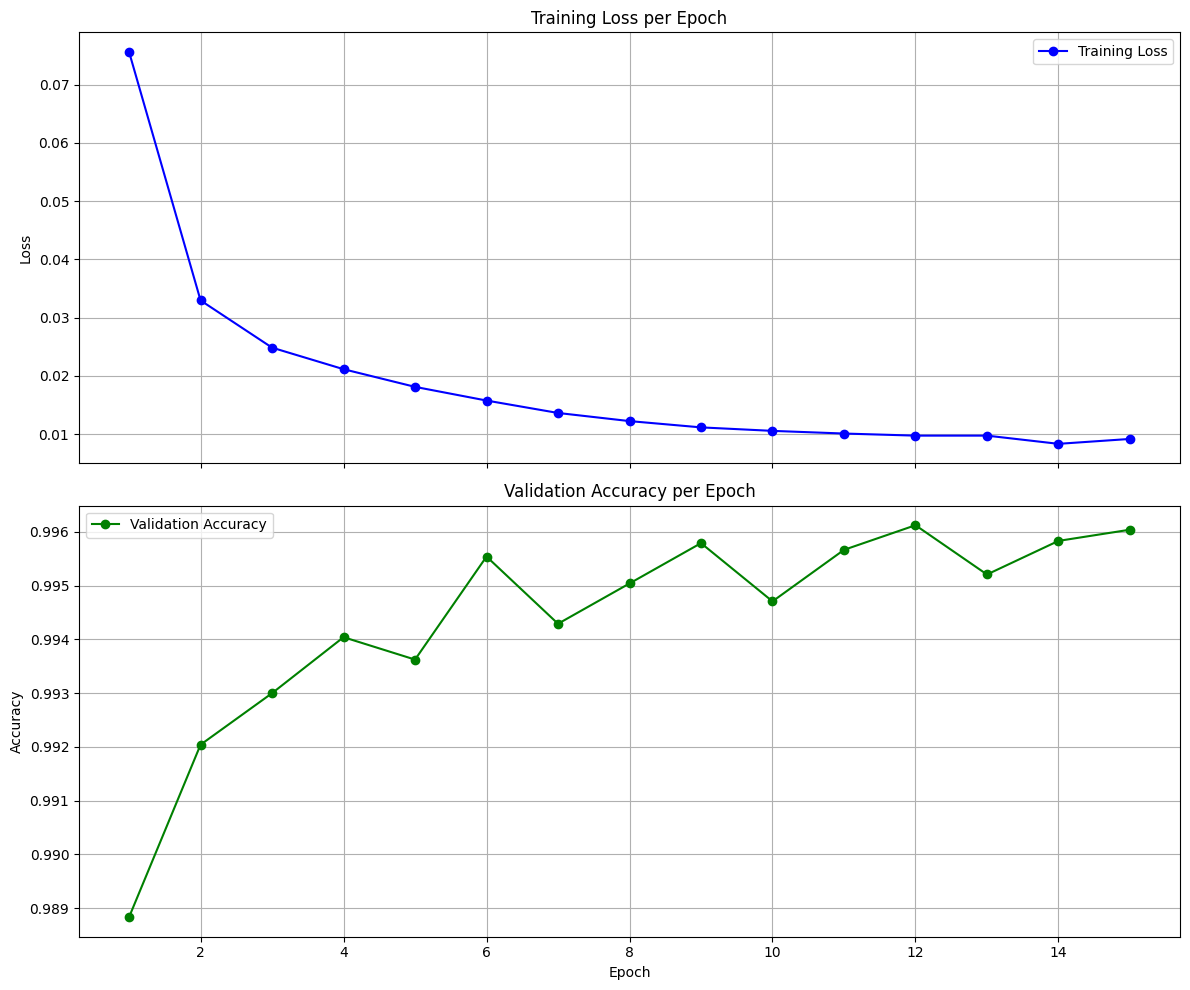

In [7]:
# --- 📊 Plot Training History ---
history_df = pd.DataFrame(training_history)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot Training Loss
ax1.plot(history_df.index + 1, history_df['train_loss'], label='Training Loss', color='blue', marker='o')
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss per Epoch")
ax1.legend()
ax1.grid(True)

# Plot Validation Accuracy
ax2.plot(history_df.index + 1, history_df['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation Accuracy per Epoch")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# --- 📈 Final Evaluation on Validation Set ---

# --- Load the best model ---
best_model_path = os.path.join(CHECKPOINT_DIR, BEST_MODEL_NAME)
if os.path.exists(best_model_path):
    print(f"--- Loading best model from '{BEST_MODEL_NAME}' for final evaluation ---")
    eval_model = SignalCNN2D(input_shape_for_model).to(device)
    eval_model.load_state_dict(torch.load(best_model_path))
    eval_model.eval()

    # --- Get predictions on the validation set ---
    y_pred = []
    y_true = []

    with torch.no_grad():
        for spectrograms, labels in val_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.unsqueeze(1)
            outputs = eval_model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
else:
    print(f"Best model checkpoint '{BEST_MODEL_NAME}' not found. Skipping final evaluation.")
    y_pred, y_true = None, None

--- Loading best model from 'best_model.pth' for final evaluation ---


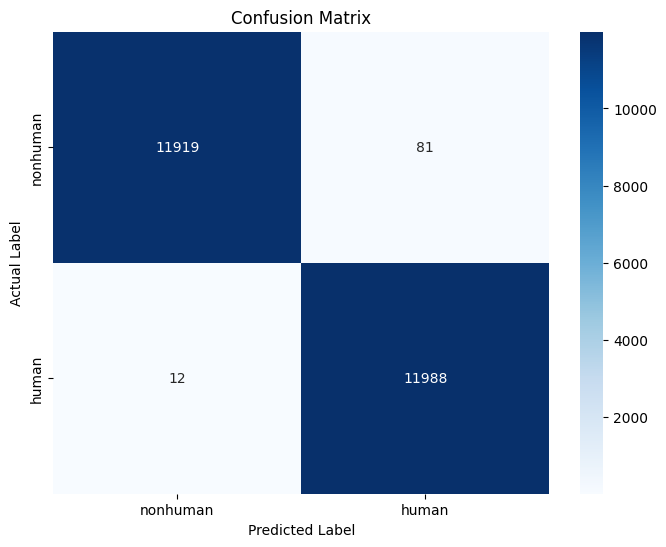

Overall Validation Accuracy: 99.61%

Classification Report
              precision    recall  f1-score   support

    nonhuman       1.00      0.99      1.00     12000
       human       0.99      1.00      1.00     12000

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



In [9]:
# --- 🔢 Step 9: Plot Confusion Matrix & Classification Report ---

if y_pred and y_true:
    # --- 1. Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['nonhuman', 'human']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate and print overall accuracy as a percentage
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Validation Accuracy: {accuracy * 100:.2f}%")

    # --- 2. Classification Report ---
    print("\n" + "="*50)
    print("Classification Report")
    print("="*50)
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)